In [1]:
import os
import pandas as pd
import shutil
import tensorflow as tf
import requests
import numpy as np
import PIL
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm as tq
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import load_model
#from efficientnet.tfkeras import EfficientNetB1, EfficientNetB4

from io import BytesIO
from PIL import Image

In [2]:
mypath= 'radiography/'

In [3]:
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [4]:
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
covid        100
lung         100
normal       100
pneumonia    100
dtype: int64

In [5]:
df.head()

,path,file_name,tag
0,radiography/covid\COVID-1.png,COVID-1.png,covid
1,radiography/covid\COVID-10.png,COVID-10.png,covid
2,radiography/covid\COVID-100.png,COVID-100.png,covid
3,radiography/covid\COVID-11.png,COVID-11.png,covid
4,radiography/covid\COVID-12.png,COVID-12.png,covid


In [6]:
X= df['path']
y= df['tag']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=5)

In [8]:
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=2)

In [9]:
df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_te = pd.DataFrame({'path':X_test
              ,'tag':y_test
             ,'set':'test'})

df_val = pd.DataFrame({'path':X_val
              ,'tag':y_val
             ,'set':'validation'})

In [10]:
print('train size', len(df_tr))
print('val size', len(df_te))
print('test size', len(df_val))

train size 320
val size 40
test size 40


In [11]:
# melihat proporsi pada masing masing set apakah sudah ok atau masih ada yang ingin diubah
df_all = pd.concat([df_te,df_val,df_tr]).reset_index(drop=1)


print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

#cek sample datanya
df_all.sample(3)


set         tag      
test        covid         9
            lung         11
            normal        8
            pneumonia    12
train       covid        82
            lung         81
            normal       83
            pneumonia    74
validation  covid         9
            lung          8
            normal        9
            pneumonia    14
dtype: int64 




,path,tag,set
193,radiography/lung\Lung_Opacity-98.png,lung,train
135,radiography/covid\COVID-61.png,covid,train
354,radiography/normal\Normal-76.png,normal,train


In [12]:
datasource_path = "radiography/"
dataset_path = "dataset/"

In [13]:
for index, row in tq(df_all.iterrows()):
    
    #detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],destination_file_name)
    
    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest,follow_symlinks=True)

0it [00:00, ?it/s]

In [14]:
# Parameter input untuk network
dim = (150, 150)
# dim = (456, 456)
channel = (3, )
input_shape = dim + channel
# Batch size
batch_size = 16
# Epoch
epoch = 10

In [15]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

In [16]:
# binary = [1,0,0,0,0] [0,1,0,0,0] [0,0,1,0,0] [0,0,0,1,0] [0,0,0,0,1]
# categorical = 1,2,3,4,5

train_generator = train_datagen.flow_from_directory('dataset/train/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory('dataset/validation/',
                                                target_size=dim,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_datagen.flow_from_directory('dataset/test/',
                                                  target_size=dim,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)

num_class = test_generator.num_classes
labels = train_generator.class_indices.keys()

Found 320 images belonging to 4 classes.
Found 40 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


In [17]:
print(labels)

dict_keys(['covid', 'lung', 'normal', 'pneumonia'])


In [18]:
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

In [19]:
train_data = tf_data_generator(train_generator, input_shape)
test_data = tf_data_generator(test_generator, input_shape)
val_data = tf_data_generator(val_generator, input_shape)

In [20]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=input_shape))

model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class))
model.add(Activation('softmax'))

model.summary()

# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 128)     3584      
_________________________________________________________________
activation (Activation)      (None, 150, 150, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 32)      36896     
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        1

In [21]:
history = model.fit(x=train_data,
        steps_per_epoch=len(train_generator),
        epochs= 10,
        validation_data=val_data,
        validation_steps=len(val_generator),
        shuffle=True,
        verbose = 1)

Epoch 1/10
20/20 [==============================] - 57s 3s/step - loss: 1.7000 - accuracy: 0.2750 - val_loss: 1.3791 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 43s 2s/step - loss: 1.3454 - accuracy: 0.3844 - val_loss: 1.1887 - val_accuracy: 0.5250
Epoch 3/10
20/20 [==============================] - 46s 2s/step - loss: 1.2021 - accuracy: 0.4250 - val_loss: 1.1399 - val_accuracy: 0.4750
Epoch 4/10
20/20 [==============================] - 52s 3s/step - loss: 1.1928 - accuracy: 0.4531 - val_loss: 1.1063 - val_accuracy: 0.5500
Epoch 5/10
20/20 [==============================] - 58s 3s/step - loss: 1.1831 - accuracy: 0.4656 - val_loss: 1.0432 - val_accuracy: 0.5250
Epoch 6/10
20/20 [==============================] - 61s 3s/step - loss: 1.1228 - accuracy: 0.4906 - val_loss: 1.0745 - val_accuracy: 0.6250
Epoch 7/10
20/20 [==============================] - 63s 3s/step - loss: 1.1110 - accuracy: 0.5250 - val_loss: 1.1264 - val_accuracy: 0.4500
Epoch 8/10
20/20 [==

In [22]:
history.history['loss']

[1.7000328302383423,
 1.3454127311706543,
 1.2021188735961914,
 1.1928085088729858,
 1.1831345558166504,
 1.1227657794952393,
 1.1109545230865479,
 1.096144437789917,
 1.0640900135040283,
 1.056584358215332]

In [23]:
history.history['accuracy']

[0.2750000059604645,
 0.3843750059604645,
 0.42500001192092896,
 0.453125,
 0.46562498807907104,
 0.4906249940395355,
 0.5249999761581421,
 0.512499988079071,
 0.5249999761581421,
 0.515625]

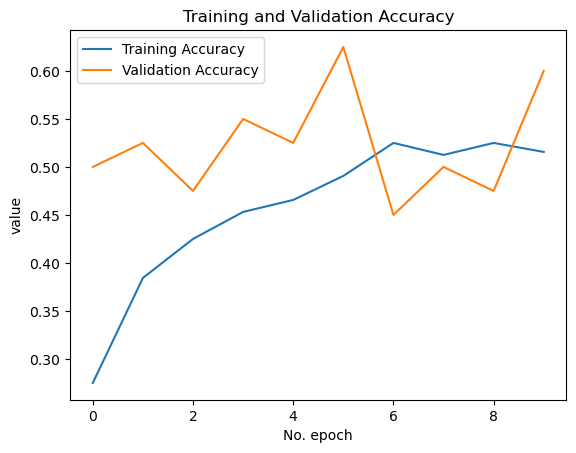

In [24]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

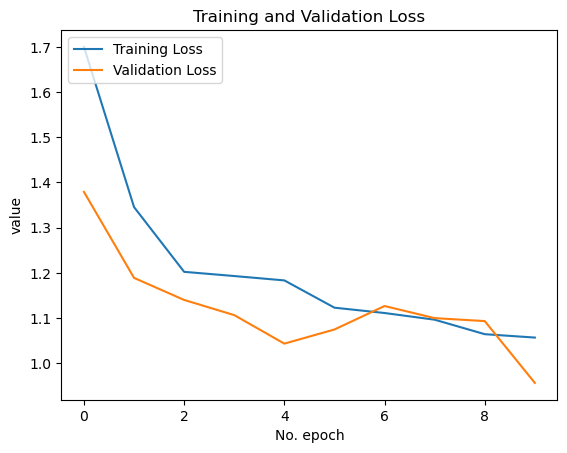

In [25]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [26]:
MODEL_BASE_PATH = "model"
PROJECT_NAME = "medium_project"
SAVE_MODEL_NAME = "model16.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model.save(save_model_path,include_optimizer=False)

Saving Model At model\medium_project\model16.h5...


In [27]:
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')

Accuracy on training data: 0.4750 
Loss on training data: 1.0190 

Accuracy on test data: 0.5250 
Loss on test data: 1.0502 



In [28]:
score = model.evaluate(test_generator)
print('Accuray: ', score[1]*100, "%")

3/3 [==============================] - 1s 334ms/step - loss: 1.0057 - accuracy: 0.5250
Accuray:  52.49999761581421 %


In [29]:
# Parameters
input_size = (150,150)

#define input shape
channel = (3,)
input_shape = input_size + channel

#define labels
labels = ['covid','lung','normal','pneumonia']

In [31]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

In [32]:
# ada 2 cara load model, jika cara pertama berhasil maka bisa lasngusng di lanjutkan ke fungsi prediksi

MODEL_PATH = 'model/medium_project/model16.h5'
model = load_model(MODEL_PATH,compile=False)

lung 0.37343094


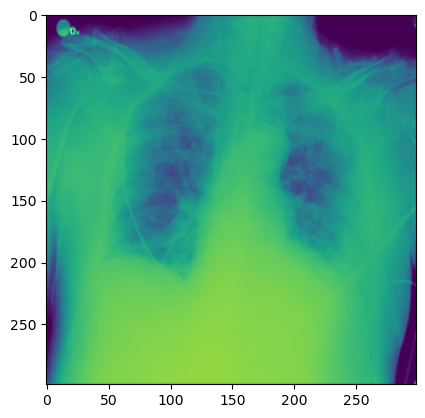

In [33]:
# read image
im = Image.open('radiography/covid/COVID-1.png')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

plt.imshow(im)

print( labels[np.argmax(y)], np.max(y) )

lung 0.8598375


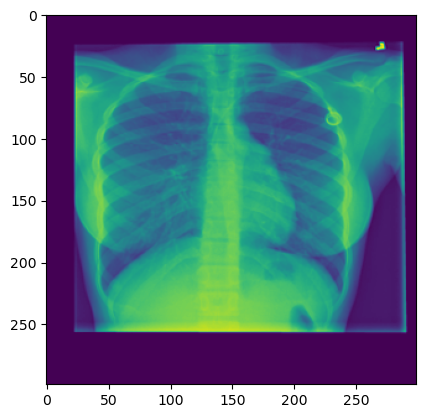

In [34]:
# read image
im = Image.open('radiography/normal/Normal-1.png')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

plt.imshow(im)

print( labels[np.argmax(y)], np.max(y) )

lung 0.563913


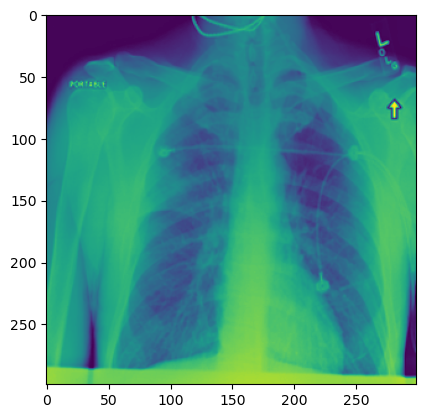

In [35]:
# read image
im = Image.open('radiography/lung/Lung_Opacity-3.png')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

plt.imshow(im)

print( labels[np.argmax(y)], np.max(y) )

pneumonia 0.8493322


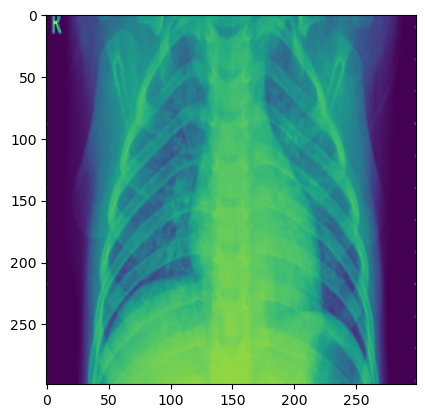

In [36]:
# read image
im = Image.open('radiography/pneumonia/Viral Pneumonia-6.png')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

plt.imshow(im)

print( labels[np.argmax(y)], np.max(y) )

lung 0.44100952


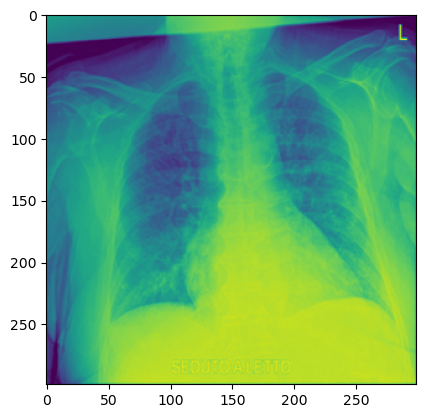

In [37]:
# read image
im = Image.open('radiography/covid/Covid-7.png')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

plt.imshow(im)

print( labels[np.argmax(y)], np.max(y) )

normal 0.5070476


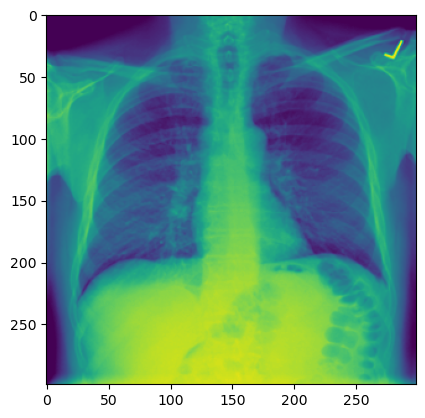

In [38]:
# read image
im = Image.open('radiography/normal/normal-12.png')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

plt.imshow(im)

print( labels[np.argmax(y)], np.max(y) )

lung 0.46380904


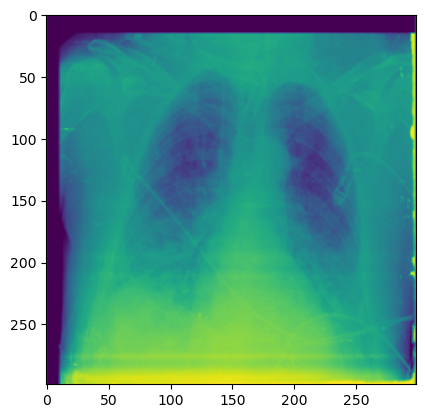

In [39]:
# read image
im = Image.open('radiography/covid/Covid-9.png')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

plt.imshow(im)

print( labels[np.argmax(y)], np.max(y) )